# Capstone 2 - Baseball Stat Projections - Pre-Processing

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.feature_selection import RFE
from sklearn.dummy import DummyRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error
import statsmodels.api as sm 
import statsmodels.regression as smr
plt.style.use('ggplot')

In [2]:
path = "/Users/joeboardman/Documents/Springboard/GitHub/Capstone-Two/data"
metrics_save_path = "/Users/joeboardman/Documents/Springboard/GitHub/Capstone-Two/models/"
fig_save_path = "/Users/joeboardman/Documents/Springboard/GitHub/Capstone-Two/figures/"
os.chdir(path)
df = pd.read_csv('Baseball_DW.csv', index_col=0)
df_mae_test = pd.read_csv('Baseball_DW.csv', index_col=0)
df.head()

,player_id,year,salary,age,ops,ops_lg,season_ops,lg_wOBAScale,ops_1,so_1,...,g_2b_prev_2,g_3b_prev_2,g_ss_prev_2,g_of_prev_2,g_dh_prev_2,power,speed,contact,lucky_1,lucky_2
0,abbotku01,1996,250000,27,0.735,0.767128,0.755118,1.171,0.773,110.0,...,0.0,0.0,107.0,0.0,0.0,0,0,0,1,1
1,abbotku01,1997,650000,28,0.747,0.756034,0.757387,1.201,0.735,99.0,...,10.0,16.5,79.5,0.0,0.0,0,0,0,1,1
2,abbotku01,1999,900000,30,0.741,0.778393,0.758506,1.156,0.747,68.0,...,37.0,18.5,25.5,5.0,0.0,0,0,0,1,1
3,abreubo01,2000,2933333,26,0.972,0.782061,0.757387,1.147,0.998,113.0,...,0.0,0.0,0.0,146.0,2.5,0,0,1,1,1
4,abreubo01,2001,4983000,27,0.941,0.758842,0.762669,1.182,0.972,116.0,...,0.0,0.0,0.0,149.0,2.5,0,0,1,1,1


In [3]:
# Break out response variable and scale data

X = df.drop(['player_id', 'ops'], axis=1)

y = df.ops

scaler = StandardScaler().fit(X)

X_scaled = scaler.transform(X)


In [4]:
# Split data into training and test splits

y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=34)


# Capstone 2 - Baseball Stat Projections - Modeling

### OPS vs last year's and previous 2 years' OPS Mean Absolute Error

In [5]:
mae_lastyr = mean_absolute_error(df_mae_test.ops, df_mae_test.ops_1)
mae_prev2 = mean_absolute_error(df_mae_test.ops, df_mae_test.ops_prev_2)
print('Mean Absolute Average using OPS-1 vs OPS:', mae_lastyr.round(3))
print('Mean Absolute Average using previous 2 years OPS vs OPS:', mae_prev2.round(3))

Mean Absolute Average using OPS-1 vs OPS: 0.076
Mean Absolute Average using previous 2 years OPS vs OPS: 0.07


### Model 1 - Linear Regression:

In [6]:
# Model 1 - Linear Regression

fit_start_time_linreg = time.time()

lin_reg = LinearRegression()
model_linreg = lin_reg.fit(X_train, y_train)

fit_end_time_linreg = time.time()

y_pred_linreg = model_linreg.predict(X_test)

# Evaluation Metrics
r2_linreg = r2_score(y_test, y_pred_linreg)
mae_linreg = mean_absolute_error(y_test, y_pred_linreg)

print('R-squared:',r2_linreg)
print('Mean Absolute Error:',mae_linreg)
print('Intercept:', abs(model_linreg.intercept_))
print(pd.DataFrame(abs(lin_reg.coef_), X.columns, columns=['Coefficient']).
      sort_values(by='Coefficient', ascending=False).head(10))

test_end_time_linreg = time.time()

fit_time_linreg = fit_end_time_linreg - fit_start_time_linreg
test_time_linreg = test_end_time_linreg - fit_end_time_linreg
print('Fit time:',fit_time_linreg, 'seconds')
print('Test time:',test_time_linreg, 'seconds')

# Create row of metrics DF
metrics_linreg = ['Linear Regression', mae_linreg, r2_linreg, fit_time_linreg, test_time_linreg]

R-squared: 0.4633804529070029
Mean Absolute Error: 0.06318533761184188
Intercept: 0.7686862910089768
              Coefficient
ops_prev_2   3.163887e+12
ops_2        1.774050e+12
ops_1        1.772523e+12
g_of_prev_2  3.027263e-02
g_ss_prev_2  2.833322e-02
g_2b_prev_2  2.567830e-02
g_c_prev_2   2.261231e-02
g_3b_prev_2  2.130159e-02
ab_prev_2    1.662276e-02
g_1b_prev_2  1.632274e-02
Fit time: 0.02501821517944336 seconds
Test time: 0.008759021759033203 seconds


In [7]:
# Cross Validating Linear Regression
scores = cross_val_score(lin_reg, X_train, y_train, scoring='r2', cv=5)
print('Cross Validation R-squared scores:', scores)
print('Mean Cross Validation R-squared:', np.mean(scores))

Cross Validation R-squared scores: [0.49197519 0.45363298 0.4827086  0.51727917 0.42841421]
Mean Cross Validation R-squared: 0.47480203048178743


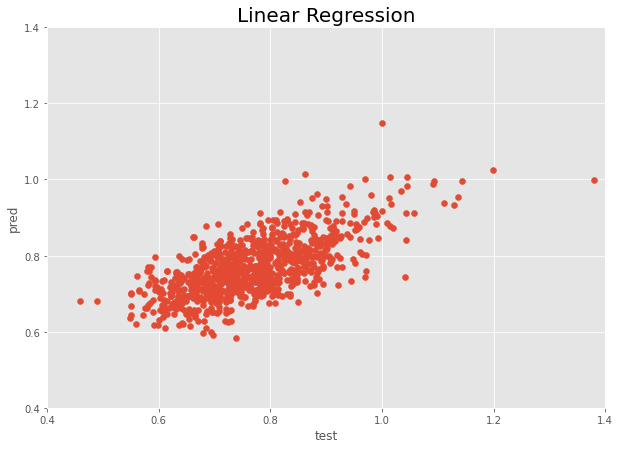

In [8]:
# Model 1 visual
fig_linreg = plt.figure(figsize=(10,7))
fig_linreg = plt.scatter(y_test, y_pred_linreg)
#fig_linreg = plt.rcParams["figure.figsize"] = (10, 7)
plt.title('Linear Regression', fontsize=20)
plt.xlim(0.4, 1.4)
plt.ylim(0.4, 1.4)
plt.xlabel('test')
plt.ylabel('pred')
plt.show()
plt.close()

fig_linreg.figure.savefig(fig_save_path + 'LinReg Predictions.png')

In [9]:
# *****TEST*****

df_X_test_lr = pd.DataFrame(data=X_test, columns=X.columns).reset_index(drop=True)
df_y_test_lr = pd.DataFrame(data=y_test, columns=['ops'])
df_y_pred_lr = pd.DataFrame(data=y_pred_linreg, columns=['ops_pred'])

df_diff_all_lr = pd.concat([df_X_test_lr, df_y_test_lr, df_y_pred_lr], axis=1) 
df_diff_all_lr['diffcol'] = df_diff_all_lr.ops_pred - df_diff_all_lr.ops

cols = ['year', 'salary', 'age', 'ops_lg', 'season_ops',
       'lg_wOBAScale', 'ops_1', 'so_1', 'ops_2', 'ops_prev_2', 'bb%_prev_2',
       'k%_prev_2', 'XBA%_prev_2', 'ab_prev_2', 'avg_prev_2', 'BABIP_prev_2',
       'g_c_prev_2', 'g_1b_prev_2', 'g_2b_prev_2', 'g_3b_prev_2',
       'g_ss_prev_2', 'g_of_prev_2', 'g_dh_prev_2']

for col in cols:
    df_diff_all_lr[col] = (df_diff_all_lr[col] * X[col].std()) + X[col].mean()
    
df_diff_all_lr = df_diff_all_lr.round(3)

print(df_diff_all_lr.diffcol.nlargest(1))
print(df_diff_all_lr.diffcol.nsmallest(1))
df_diff_all_lr.dropna(how='any', inplace=True)


236    0.221
Name: diffcol, dtype: float64
871   -0.381
Name: diffcol, dtype: float64


In [10]:
# *****TEST*****
df_dig_lr = df_diff_all_lr[['year', 'salary', 'age', 'ops_1', 'ops_2', 'ops_prev_2', 'ops', 'ops_pred', 'diffcol']]

df_dig_lr.iloc[[871]]
#df_dig_lr[df_dig_lr.ops == 1.0]

,year,salary,age,ops_1,ops_2,ops_prev_2,ops,ops_pred,diffcol
871,2001.0,1.030052e+07,37.0,1.132,1.009,1.071,1.38,0.999,-0.381


In [11]:
df_var_lr = df[['player_id', 'year', 'age', 'ops', 'ops_1', 'ops_2']]
df_var_lr[df_var_lr.ops == 1.38]

,player_id,year,age,ops,ops_1,ops_2
540,bondsba01,2001,37,1.38,1.132,1.009


### Model 2 - Random Forest with All Features:

In [12]:
# Split data for ensemble models

X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = train_test_split(X, y, test_size=0.15, random_state=34)

#### GridSearchCV on RF Model:

In [52]:
# Random Forest GridSearch

start_time_GS_cv = time.time()

# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [5, 10, 15, 20, 30, 40, 50, 75, 100]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 7, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

param_grid = {'max_depth':max_depth,
             'max_features':max_features,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
             'bootstrap':bootstrap}
rfr = RandomForestRegressor()
rfr_gs = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1)

rfr_gs.fit(X_train_ensemble, y_train_ensemble)

end_time_GS_cv = time.time()
print('Run time:',end_time_GS_cv - start_time_GS_cv, 'seconds')
print(rfr_gs.best_params_)

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 55.9min finished


Run time: 3356.6399660110474 seconds
{'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}


In [53]:
# Evaluation formula
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

# Run model with best parameters

rfr_gridsearch = rfr_gs.best_estimator_
rfr_gridsearch.fit(X_train_ensemble, y_train_ensemble)
gs_accuracy = evaluate(rfr_gridsearch, X_test_ensemble, y_test_ensemble)



Model Performance
Average Error: 0.0638 degrees.
Accuracy = 91.57%.


In [13]:
# Model 2 - Random Forest Regression

fit_start_time_rfr_all = time.time()

rfr = RandomForestRegressor(n_estimators=1000, bootstrap=True, max_depth=30, max_features='sqrt', 
                            min_samples_leaf=1, min_samples_split=7,random_state=34)
#rfr = RandomForestRegressor(n_estimators=100, random_state=34)

model_rfr_all = rfr.fit(X_train_ensemble, y_train_ensemble)

fit_end_time_rfr_all = time.time()

y_pred_rfr_all = model_rfr_all.predict(X_test_ensemble)

# Evaluation Metrics
r2_rfr_all = r2_score(y_test_ensemble, y_pred_rfr_all)
mae_rfr_all = mean_absolute_error(y_test_ensemble, y_pred_rfr_all)

print('R-squared:',r2_rfr_all)
print('Mean Absolute Error:',mae_rfr_all)

test_end_time_rfr_all = time.time()

fit_time_rfr_all = fit_end_time_rfr_all - fit_start_time_rfr_all
test_time_rfr_all = test_end_time_rfr_all - fit_end_time_rfr_all
print('Fit time:',fit_time_rfr_all, 'seconds')
print('Test time:',test_time_rfr_all, 'seconds')

# Create row of metrics DF
metrics_rfr_all = ['Random Forest Regression', mae_rfr_all, r2_rfr_all, fit_time_rfr_all, test_time_rfr_all]


R-squared: 0.4510161314475253
Mean Absolute Error: 0.06353120756252682
Fit time: 11.135334730148315 seconds
Test time: 0.24969196319580078 seconds


In [14]:
# *****TEST*****

df_X_test = pd.DataFrame(data=X_test_ensemble, columns=X.columns).reset_index(drop=True)
df_y_test = pd.DataFrame(data=y_test_ensemble, columns=['ops'])
df_y_pred = pd.DataFrame(data=y_pred_rfr_all, columns=['ops_pred'])

df_diff_all = pd.concat([df_X_test, df_y_test, df_y_pred], axis=1) 
df_diff_all['diffcol'] = df_diff_all.ops_pred - df_diff_all.ops

cols = ['year', 'salary', 'age', 'ops_lg', 'season_ops',
       'lg_wOBAScale', 'ops_1', 'so_1', 'ops_2', 'ops_prev_2', 'bb%_prev_2',
       'k%_prev_2', 'XBA%_prev_2', 'ab_prev_2', 'avg_prev_2', 'BABIP_prev_2',
       'g_c_prev_2', 'g_1b_prev_2', 'g_2b_prev_2', 'g_3b_prev_2',
       'g_ss_prev_2', 'g_of_prev_2', 'g_dh_prev_2']

for col in cols:
    df_diff_all[col] = (df_diff_all[col] * X[col].std()) + X[col].mean()
    
df_diff_all = df_diff_all.round(3)

print(df_diff_all.diffcol.nlargest(1))
print(df_diff_all.diffcol.nsmallest(1))
df_diff_all.dropna(how='any', inplace=True)


485    0.229
Name: diffcol, dtype: float64
871   -0.383
Name: diffcol, dtype: float64


In [15]:
# *****TEST*****
df_dig = df_diff_all[['year', 'salary', 'age', 'ops_1', 'ops_2', 'ops_prev_2', 'ops', 'ops_pred', 'diffcol']]

df_dig.iloc[[871]]


,year,salary,age,ops_1,ops_2,ops_prev_2,ops,ops_pred,diffcol
871,18267.821,4.499704e+13,165.12,0.899,0.888,0.881,1.38,0.997,-0.383


In [16]:
df_var = df[['player_id', 'year', 'age', 'ops', 'ops_1', 'ops_2']]
df_var[df_var.ops_1 == 1.38]

,player_id,year,age,ops,ops_1,ops_2
541,bondsba01,2002,38,1.383,1.38,1.132


30


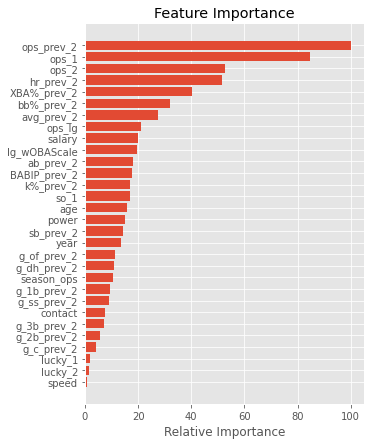

In [17]:
feature_importance_rfr_all = model_rfr_all.feature_importances_
# make importances relative to max importance
feature_importance_rfr_all = 100.0 * (feature_importance_rfr_all / feature_importance_rfr_all.max())
sorted_idx_rfr_all = np.argsort(feature_importance_rfr_all)

pos_rfr_all = np.arange(sorted_idx_rfr_all.shape[0]) + .5
print(pos_rfr_all.size)
sorted_idx_rfr_all.size
plt.figure(figsize=(5,7))
plt.barh(pos_rfr_all, feature_importance_rfr_all[sorted_idx_rfr_all], align='center')
plt.yticks(pos_rfr_all, X.columns[sorted_idx_rfr_all])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()
plt.close()

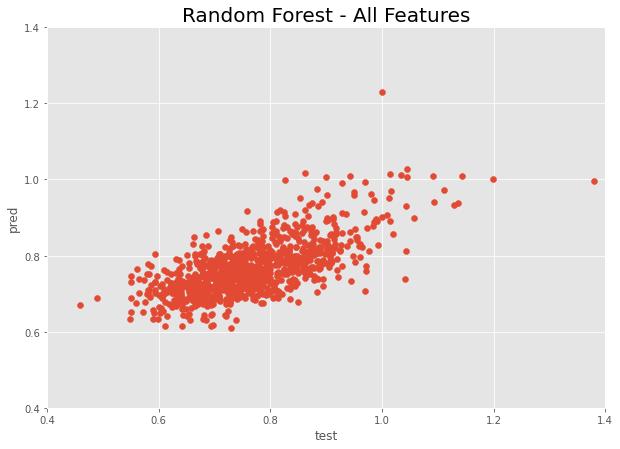

In [18]:
# Model 2 visual
fig_rfr = plt.figure(figsize=(10,7))
fig_rfr = plt.scatter(y_test_ensemble, y_pred_rfr_all)
plt.title('Random Forest - All Features', fontsize=20)
plt.xlim(0.4, 1.4)
plt.ylim(0.4, 1.4)
plt.xlabel('test')
plt.ylabel('pred')
plt.show()
plt.close()

fig_rfr.figure.savefig(fig_save_path + 'RFR Predictions.png')

### Model 4 - Gradient Boosting Model:

#### GridSearchCV on Model 4:

In [41]:
# Gradient Boosting GridSearch

start_time_gb_GS_cv = time.time()

max_features = ['log2', 'sqrt', 'auto']
max_depth = [1,3,5,10]
max_depth.append(None)
learning_rate=[0.01, 0.1]

param_grid_gb = {'max_depth':max_depth,
             'max_features':max_features,
             'n_estimators':n_estimators,
             'learning_rate':learning_rate}
gb = GradientBoostingRegressor()
gb_gs = GridSearchCV(estimator = gb, param_grid = param_grid_gb, cv = 3, verbose=2, n_jobs = -1)

gb_gs.fit(X_train, y_train)

end_time_gb_GS_cv = time.time()
print('Run time:',end_time_gb_GS_cv - start_time_gb_GS_cv, 'seconds')
gb_gs.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


Run time: 69.92539310455322 seconds


{'learning_rate': 0.1,
 'max_depth': 3,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [42]:
# Evaluation formula
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Mean Absolute Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Mean Absolute Percentage Error = {:0.2f}%.'.format(accuracy))
    
    return accuracy

# Run the model with the best parameters
gb_gridsearch = gb_gs.best_estimator_
gb_gridsearch.fit(X_train_ensemble, y_train_ensemble)
gs_gb_accuracy = evaluate(gb_gridsearch, X_test_ensemble, y_test_ensemble)

Model Performance
Average Mean Absolute Error: 0.0628 degrees.
Mean Absolute Percentage Error = 91.69%.


In [19]:
# Gradient Boosting Model

fit_start_time_gb = time.time()

gb = GradientBoostingRegressor(n_estimators=100, max_depth=3, max_features = 'sqrt', learning_rate=0.1, 
                               random_state=34)
#gb = GradientBoostingRegressor(n_estimators=100, random_state=34)

gb.fit(X_train_ensemble, y_train_ensemble)

fit_end_time_gb = time.time()

y_pred_gb = gb.predict(X_test_ensemble)

r2_gb = r2_score(y_test_ensemble, y_pred_gb)
mae_gb = mean_absolute_error(y_test_ensemble, y_pred_gb)

print('R-squared:',r2_gb)
print('Mean Absolute Error:',mae_gb)

test_end_time_gb = time.time()

fit_time_gb = fit_end_time_gb - fit_start_time_gb
test_time_gb = test_end_time_gb - fit_end_time_gb
print('Fit time:',fit_time_gb, 'seconds')
print('Test time:',test_time_gb, 'seconds')

# Create row of metrics DF
metrics_gb = ['Gradient Boosting Regression', mae_gb, r2_gb, fit_time_gb, test_time_gb]


R-squared: 0.46235375063983053
Mean Absolute Error: 0.06276995207601484
Fit time: 0.5562939643859863 seconds
Test time: 0.006417036056518555 seconds


In [20]:
# *****TEST*****

df_X_test_gb = pd.DataFrame(data=X_test_ensemble, columns=X.columns).reset_index(drop=True)
df_y_test_gb = pd.DataFrame(data=y_test_ensemble, columns=['ops'])
df_y_pred_gb = pd.DataFrame(data=y_pred_gb, columns=['ops_pred'])

df_diff_all_gb = pd.concat([df_X_test_gb, df_y_test_gb, df_y_pred_gb], axis=1) 
df_diff_all_gb['diffcol'] = df_diff_all_gb.ops_pred - df_diff_all_gb.ops

'''cols = ['year', 'salary', 'age', 'ops_lg', 'season_ops',
       'lg_wOBAScale', 'ops_1', 'so_1', 'ops_2', 'ops_prev_2', 'bb%_prev_2',
       'k%_prev_2', 'XBA%_prev_2', 'ab_prev_2', 'avg_prev_2', 'BABIP_prev_2',
       'g_c_prev_2', 'g_1b_prev_2', 'g_2b_prev_2', 'g_3b_prev_2',
       'g_ss_prev_2', 'g_of_prev_2', 'g_dh_prev_2']

for col in cols:
    df_diff_all_gb[col] = (df_diff_all_gb[col] * X[col].std()) + X[col].mean()'''
    
df_diff_all_gb = df_diff_all_gb.round(3)

print(df_diff_all_gb.diffcol.nlargest(1))
print(df_diff_all_gb.diffcol.nsmallest(1))
df_diff_all_gb.dropna(how='any', inplace=True)


485    0.235
Name: diffcol, dtype: float64
871   -0.399
Name: diffcol, dtype: float64


In [21]:
# *****TEST*****
df_dig_gb = df_diff_all_gb[['year', 'salary', 'age', 'ops_1', 'ops_2', 'ops_prev_2', 'ops', 'ops_pred', 'diffcol']]

df_dig_gb.iloc[[871]]


,year,salary,age,ops_1,ops_2,ops_prev_2,ops,ops_pred,diffcol
871,2001,10300000,37,1.132,1.009,1.07,1.38,0.981,-0.399


In [22]:
df_var_gb = df[['player_id', 'year', 'age', 'ops', 'ops_1', 'ops_2']]
df_var_gb[df_var_gb.ops_1 == 1.38]

,player_id,year,age,ops,ops_1,ops_2
541,bondsba01,2002,38,1.383,1.38,1.132


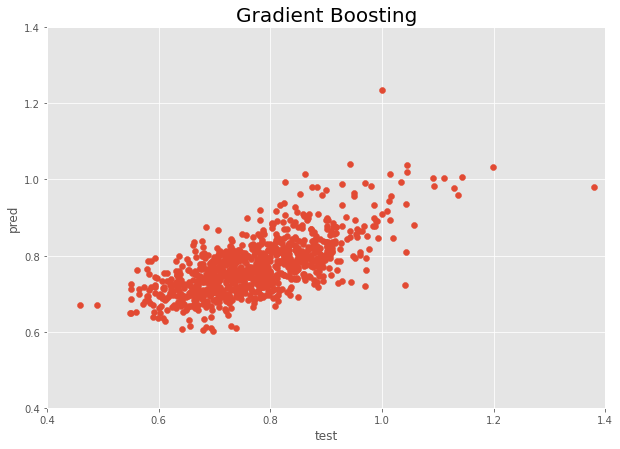

In [23]:
# Gradient Boosting Model visual
fig_gb = plt.figure(figsize=(10,7))
fig_gb = plt.scatter(y_test_ensemble, y_pred_gb)
plt.title('Gradient Boosting', fontsize=20)
plt.xlim(0.4, 1.4)
plt.ylim(0.4, 1.4)
plt.xlabel('test')
plt.ylabel('pred')
plt.show()
plt.close()

fig_gb.figure.savefig(fig_save_path + 'GB Predictions.png')

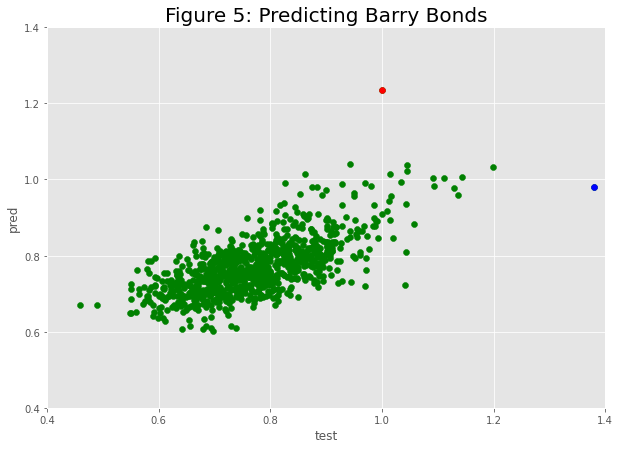

In [24]:
fig_bonds = plt.figure(figsize=(10,7))

# Plot actual vs predicted
fig_bonds = plt.scatter(df_dig_gb.ops, df_dig_gb.ops_pred, color='green')
# error when predicting bonds 2nd to last yr of career after 4 consecutive seasons of the top 8 all time OPS
fig_bonds = plt.scatter(df_dig_gb.iloc[485,6], df_dig_gb.iloc[485,7], color='red') # Bonds - last yr of career
# error when predicting bonds 73 home run year
fig_bonds = plt.scatter(df_dig_gb.iloc[871,6], df_dig_gb.iloc[871,7], color='blue') # Bonds - 73 home run year
plt.title('Figure 5: Predicting Barry Bonds', fontsize=20)
plt.xlim(0.4, 1.4)
plt.ylim(0.4, 1.4)
plt.xlabel('test')
plt.ylabel('pred')
plt.show()
plt.close()

fig_bonds.figure.savefig(fig_save_path + 'bonds Predictions.png')

In [25]:
# Metrics Dataframe
cols = ['Model', 'MAE', 'R-squared', 'fit_time', 'test_time']

df_metrics = pd.DataFrame(data=[metrics_linreg, metrics_rfr_all, metrics_gb], columns=cols).set_index('Model')
print(df_metrics.round(decimals=4))

save_metrics = os.path.join(metrics_save_path, 'df_metrics.csv')
df_metrics.to_csv(save_metrics)

                                 MAE  R-squared  fit_time  test_time
Model                                                               
Linear Regression             0.0632     0.4634    0.0250     0.0088
Random Forest Regression      0.0635     0.4510   11.1353     0.2497
Gradient Boosting Regression  0.0628     0.4624    0.5563     0.0064
